# Sure Independent Screening

Sure independent screening (SIS) has been shown to effectively filter out many uninformative variables in ultra-high-dimensional settings, where the number of covariates greatly exceeds the number of observations (as is common in genetic datasets, for example). Penalized variable selection methods are typically applied to the remaining covariates after screening.

In the following example, we demonstrate how such an analysis can be performed on discrete-time survival data with competing events using the `SISTwoStagesFitter` of *PyDTS*. An "Exact" version for small sample sizes is also available via `SISTwoStagesFitterExact`. 

## Data Generation

To demonstrate the screening process, we first sample a dataset with $p = 1000$ covariates and $n = 500$ observations. Clearly, $p \gg n$, placing us in an ultra-high-dimensional setting.

In [1]:
import pandas as pd
import numpy as np
from pydts.data_generation import EventTimesSampler
from pydts.screening import SISTwoStagesFitter
from pydts.cross_validation import PenaltyGridSearchCV
from pydts.fitters import TwoStagesFitter

In [2]:
n_cov = 1000
beta1 = np.zeros(n_cov)
beta1[:5] = 1.5*np.array([-0.6, 0.5, -0.5, 0.6, -0.6])
beta2 = np.zeros(n_cov)
beta2[:5] = 1.5*np.array([0.5, -0.7, 0.7, -0.5, -0.7])

real_coef_dict = {
    "alpha": {
        1: lambda t: -3.1 + 0.15 * np.log(t),
        2: lambda t: -3.2 + 0.15 * np.log(t)
    },
    "beta": {
        1: beta1,
        2: beta2
    }
}

n_patients = 500
d_times = 6
j_events = 2

ets = EventTimesSampler(d_times=d_times, j_event_types=j_events)

seed = 97
means_vector = np.zeros(n_cov)
covariance_matrix = np.identity(n_cov)

clip_value = 2.5

covariates = [f'Z{i + 1}' for i in range(n_cov)]

patients_df = pd.DataFrame(data=pd.DataFrame(data=np.random.multivariate_normal(means_vector, covariance_matrix,
                                                                                size=n_patients),
                                             columns=covariates))
patients_df.clip(lower=-1 * clip_value, upper=clip_value, inplace=True)
patients_df = ets.sample_event_times(patients_df, hazard_coefs=real_coef_dict, seed=seed)
patients_df = ets.sample_independent_lof_censoring(patients_df, prob_lof_at_t=0.01 * np.ones(d_times),
                                                   seed=seed + 1)
patients_df = ets.update_event_or_lof(patients_df)
patients_df.index.name = 'pid'
patients_df = patients_df.reset_index()

The resulting dataset contains the following observed event-types and event-times:

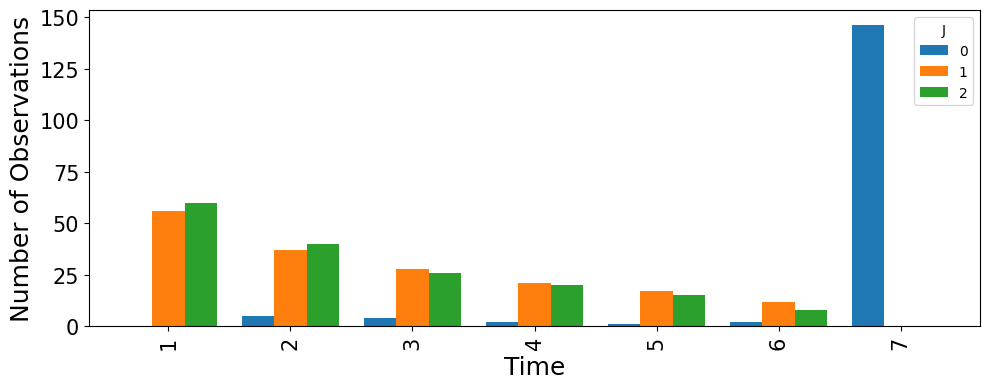

In [3]:
from pydts.examples_utils.plots import plot_events_occurrence
plot_events_occurrence(patients_df)

## SIS

`SISTwoStagesFitter` implements the screening process. As described in the Methods section, we fit marginal estimates for the $\beta_j$ coefficients using both the original data and permuted data that follow the null model. The maximum absolute value of the marginal coefficients from the null model (fitted using the permuted data) is selected as a data-driven threshold. We then retain only those variables whose marginal coefficients from the original data exceed this threshold.

In [5]:
fitter = SISTwoStagesFitter()
fitter.fit(df=patients_df.drop(['C', 'T'], axis=1), seed=10)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   13.7s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   22.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   34.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   20.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   32.7s finished


The results of the marginal estimates under the null model using permuted data, the marginal estimates using the original data, and the data-driven threshold are provided below.

In [6]:
fitter.null_model_df

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,-0.051194,0.079323,-0.109907,0.079738
Z2,0.018975,0.082467,-0.032187,0.082622
Z3,-0.048221,0.074646,-0.129129,0.076010
Z4,-0.034971,0.076312,-0.056456,0.076418
Z5,0.034691,0.073673,-0.043497,0.074451
...,...,...,...,...
Z996,-0.068723,0.084455,-0.029909,0.084860
Z997,0.199384,0.079347,-0.141407,0.078816
Z998,0.048464,0.075687,0.029086,0.075630


In [7]:
fitter.threshold

0.24893913811535112

In [8]:
fitter.marginal_estimates_df

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,-0.440522,0.080529,0.290845,0.078372
Z2,0.450510,0.083694,-0.661550,0.084618
Z3,-0.439468,0.082773,0.524361,0.077278
Z4,0.672241,0.081552,-0.496182,0.078566
Z5,-0.458879,0.080453,-0.714228,0.083198
...,...,...,...,...
Z996,-0.001290,0.080151,-0.098645,0.080883
Z997,0.144605,0.078395,0.142037,0.079094
Z998,-0.069460,0.073183,-0.012518,0.072763


The informative coefficients that exceed the threshold are selected separately for each event type:

In [9]:
fitter.chosen_covariates_j

{1: ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z95'],
 2: ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z198', 'Z355']}

Evidently, we successfully identified all informative variables ($Z_1$–$Z_5$) and filtered out almost all non-informative ones, except for one false positive in event-type 1 ($Z_{95}$) and two false positives ($Z_{198}$, $Z_{355}$) in event-type 2. Now, we can use the selected variables to train a `TwoStagesFitter` as follows.

In [10]:
selected_covariates = list(np.unique(fitter.chosen_covariates_j[1]+fitter.chosen_covariates_j[2]))

two_step = TwoStagesFitter()
two_step.fit(patients_df[['pid', 'X', 'J'] + selected_covariates], covariates=fitter.chosen_covariates_j)
two_step.get_beta_SE()

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,-0.677825,0.078953,0.460589,0.086621
Z2,0.615446,0.086701,-0.953396,0.096915
Z3,-0.651071,0.093876,0.668352,0.078943
Z4,0.802648,0.081182,-0.639696,0.084932
Z5,-0.724804,0.090150,-0.815123,0.084053
Z95,0.102926,0.083056,NaN,NaN
Z198,NaN,NaN,0.139889,0.081325
Z355,NaN,NaN,-0.205345,0.083858


## Adding LASSO (SIS-L)

As an additional variable selection step, LASSO regression can be applied to the set of covariates retained by the screening process.

To select the optimal penalization parameter, we perform a penalty grid search using cross-validation and the evaluation metrics described in the Methods section. By default, model selection is guided by the global-AUC metric.

In [11]:
step = 0.5
penalizers = np.arange(-8., -1.4, step=step) 
n_splits = 3

In [12]:
penalty_cv_search = PenaltyGridSearchCV()
gauc_cv_results = penalty_cv_search.cross_validate(full_df=patients_df[['pid', 'X', 'J'] + selected_covariates], 
                                                   l1_ratio=1, 
                                                   penalizers=np.exp(penalizers),  
                                                   n_splits=n_splits, 
                                                   seed=20)

Starting fold 1/3
Started estimating the coefficients for penalizer 0.00033546262790251185 (1/14)
Finished estimating the coefficients for penalizer 0.00033546262790251185 (1/14), 0 seconds
Started estimating the coefficients for penalizer 0.0005530843701478336 (2/14)
Finished estimating the coefficients for penalizer 0.0005530843701478336 (2/14), 0 seconds
Started estimating the coefficients for penalizer 0.0009118819655545162 (3/14)
Finished estimating the coefficients for penalizer 0.0009118819655545162 (3/14), 0 seconds
Started estimating the coefficients for penalizer 0.0015034391929775724 (4/14)
Finished estimating the coefficients for penalizer 0.0015034391929775724 (4/14), 0 seconds
Started estimating the coefficients for penalizer 0.0024787521766663585 (5/14)
Finished estimating the coefficients for penalizer 0.0024787521766663585 (5/14), 0 seconds
Started estimating the coefficients for penalizer 0.004086771438464067 (6/14)
Finished estimating the coefficients for penalizer 0

array([-5. , -6.5])

The mean and standard error (SE) of the global-AUC, calculated via cross-validation for all possible combinations of penalization parameters, are as follows:

In [13]:
gauc_cv_results

Mean        SE
0.000335 0.000335  0.839310  0.016736
         0.000553  0.839301  0.017051
         0.000912  0.839296  0.017185
         0.001503  0.839121  0.017664
         0.002479  0.839049  0.017628
         0.004087  0.838560  0.017396
         0.006738  0.838120  0.017466
         0.011109  0.837332  0.016710
         0.018316  0.833451  0.013611
         0.030197  0.821111  0.007837
         0.049787  0.783010  0.011579
         0.082085  0.772589  0.016024
         0.135335  0.772869  0.016011
         0.223130  0.772824  0.016058
0.000553 0.000335  0.839319  0.016691
         0.000553  0.839215  0.016970
         0.000912  0.839322  0.017114
         0.001503  0.839048  0.017512
         0.002479  0.839088  0.017568
         0.004087  0.838381  0.017399
         0.006738  0.838048  0.017620
         0.011109  0.837413  0.016404
         0.018316  0.833464  0.013506
         0.030197  0.821080  0.007901
         0.049787  0.782982  0.012069
         0.082085  0.772556  0.016003
         0.135335  0.772837  0.015990
         0.223130  0.772791  0.016036
0.000912 0.000335  0.839445  0.016549
         0.000553  0.839508  0.016806
         0.000912  0.839674  0.017078
         0.001503  0.839211  0.017539
         0.002479  0.839136  0.017455
         0.004087  0.838765  0.017007
         0.006738  0.838096  0.017474
         0.011109  0.837514  0.016094
         0.018316  0.833507  0.013212
         0.030197  0.821264  0.007708
         0.049787  0.783023  0.012378
         0.082085  0.772664  0.016456
         0.135335  0.772945  0.016442
         0.223130  0.772899  0.016487
0.001503 0.000335  0.839244  0.016515
         0.000553  0.839205  0.016741
         0.000912  0.839271  0.017036
         0.001503  0.838917  0.017737
         0.002479  0.838679  0.017799
         0.004087  0.838435  0.017271
         0.006738  0.838051  0.017731
         0.011109  0.837635  0.016325
         0.018316  0.833447  0.013246
         0.030197  0.821356  0.007606
         0.049787  0.783343  0.012864
         0.082085  0.772856  0.016586
         0.135335  0.773137  0.016572
         0.223130  0.773091  0.016614
0.002479 0.000335  0.839097  0.016811
         0.000553  0.839035  0.016926
         0.000912  0.839103  0.017126
         0.001503  0.838893  0.017719
         0.002479  0.838964  0.017633
         0.004087  0.838691  0.017244
         0.006738  0.838744  0.017172
         0.011109  0.838227  0.015683
         0.018316  0.833432  0.012906
         0.030197  0.821181  0.006973
         0.049787  0.783506  0.012074
         0.082085  0.773286  0.015911
         0.135335  0.773566  0.015897
         0.223130  0.773520  0.015939
0.004087 0.000335  0.838782  0.016410
         0.000553  0.838854  0.016409
         0.000912  0.839057  0.016399
         0.001503  0.838994  0.016779
         0.002479  0.838890  0.016642
         0.004087  0.838758  0.016638
         0.006738  0.838664  0.017101
         0.011109  0.838381  0.015460
         0.018316  0.834031  0.011877
         0.030197  0.821658  0.006876
         0.049787  0.785117  0.012208
         0.082085  0.774618  0.015692
         0.135335  0.774898  0.015677
         0.223130  0.774853  0.015721
0.006738 0.000335  0.839506  0.015608
         0.000553  0.839563  0.015375
         0.000912  0.839494  0.015641
         0.001503  0.839695  0.015665
         0.002479  0.839303  0.015955
         0.004087  0.839278  0.015767
         0.006738  0.839070  0.015203
         0.011109  0.838922  0.014411
         0.018316  0.835204  0.011192
         0.030197  0.822213  0.005912
         0.049787  0.785897  0.012848
         0.082085  0.776100  0.015153
         0.135335  0.776380  0.015139
         0.223130  0.776335  0.015184
0.011109 0.000335  0.839046  0.016343
         0.000553  0.839020  0.016408
         0.000912  0.839202  0.016388
         0.001503  0.838919  0.016603
         0.002479  0.838946  0.016389
         0.004087  0.839008  0.016914
         0.006738  0.839067  0.01

We choose the optimal penalizers to be the ones that maximize the global-AUC, i.e., $\log(\eta_j)$, $j=1,2$, are

In [14]:
chosen_eta = np.log(gauc_cv_results['Mean'].idxmax())
chosen_eta

array([-5. , -6.5])

Lastly, we train a regularized `TwoStagesFitter` using the entire dataset and the chosen optimal penalizers:

In [15]:
L1_regularized_fitter = TwoStagesFitter()
fit_beta_kwargs = {
    'model_kwargs': {
        1: {'penalizer': np.exp(chosen_eta[0]), 'l1_ratio': 1},
        2: {'penalizer': np.exp(chosen_eta[1]), 'l1_ratio': 1}
}}
L1_regularized_fitter.fit(df = patients_df[['pid', 'X', 'J'] + selected_covariates],
                          fit_beta_kwargs = fit_beta_kwargs, covariates=fitter.chosen_covariates_j)

lasso_beta = L1_regularized_fitter.get_beta_SE() 

Thus, the final SIS-L model is 

In [16]:
lasso_beta

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,-0.545206,0.079020,0.435527,0.086359
Z2,0.510060,0.086179,-0.915843,0.095965
Z3,-0.509418,0.089982,0.645257,0.078984
Z4,0.689470,0.080248,-0.614332,0.084495
Z5,-0.567603,0.087249,-0.785802,0.083732
Z95,0.065064,0.082256,NaN,NaN
Z198,NaN,NaN,0.125372,0.081348
Z355,NaN,NaN,-0.188075,0.083523


Recall that the true non-zero $\beta_j$ values were:

In [17]:
true_values = pd.concat([pd.Series(beta1[:5]), pd.Series(beta2[:5])], axis=1)
true_values.index = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
true_values.columns = ['j1', 'j2']
true_values

,j1,j2
Z1,-0.90,0.75
Z2,0.75,-1.05
Z3,-0.75,1.05
Z4,0.90,-0.75
Z5,-0.90,-1.05


Thus, using SIS, we identified the informative variables and filtered out most of the non-informative ones. Adding LASSO as a subsequent step further reduced the false positive coefficient in event-type 1 to nearly zero. In this specific example, SIS-L did not eliminate additional false positives for event-type 2; however, given the large number of initial covariates, this still represents a substantial improvement.